In [1]:
import TDDFTinversion as td
import numpy as np

In [2]:
np1=71 #number of grid points for 1-dimension
#initialize systemparameters derived type
sysparams=td.derivedtypes.init_systemparameters(np1)
sysparams.nd=1 #number of dimensions
sysparams.npart=2 #number of particles
sysparams.xmin=-14 #minimum grid point
sysparams.xmax=14 #maximum grid point
sysparams.triplet=1 #triplet symmetry for two-electron system
sysparams.singlet=0 #singlet symmetry for two-electron system
sysparams.ct=0. #starting time
sysparams.dth=0.005 #goal time step
sysparams.occupy_case=0 #defines the initial state occupations
sysparams.dvksmax=100000000 #max derivative of density with respect to time
sysparams.pinv0minresqlp1=0 #pseudoinverse set to 0, minresqlp set to 1
sysparams.quantization=1 #Quantization
sysparams.energy=-2.67 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams)
td.keomod.buildkeo(sysparams) #build kinetic energy operator and lattice values

In [3]:
#generate derived type to store 1 and 2 body potentials
sharedvals=td.derivedtypes.init_sharedvalues(sysparams) #shared values derived type
#generate potentials, can write own program
td.potential.generate_1bodypot(sysparams,sharedvals)
td.potential.generate_2bodypot(sysparams,sharedvals)

In [4]:
#derived type that stores full wavefunction and potential
fullvals=td.derivedtypes.init_fullvalues(sysparams)
td.potential.generate_nbodypot(sysparams,sharedvals,fullvals)
td.initial_states.initializefullsystem(sysparams,fullvals)

In [5]:
#next 5 are required to develop and advance KS orbitals
dpe=np.zeros(sysparams.ntot1,dtype=np.float64) #current density
dnx=np.zeros(sysparams.ntot1,dtype=np.float64) #current derivative of density
ddnx=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density
dpenew=np.zeros(sysparams.ntot1,dtype=np.float64) #density after time step dt, taken from sysparams.dt
ddnxnew=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density after time step sysparams.dt

#placeholder for advancing full system
psinew=np.zeros(sysparams.ntot,dtype=np.complex128)

In [6]:
td.density.fullwf_density(sysparams,fullvals.psi,dpe)

In [7]:
#initialize KS orbitals system to match dpe
KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe)

In [8]:
#add driving potential for example 2
if (sysparams.npart==2):
    td.potential.add_driving_potential(sysparams,sharedvals,fullvals)

In [9]:
sysparams.dt=sysparams.dth/2



For time step from  0.010 to  0.015
Density error = 9.94e-12


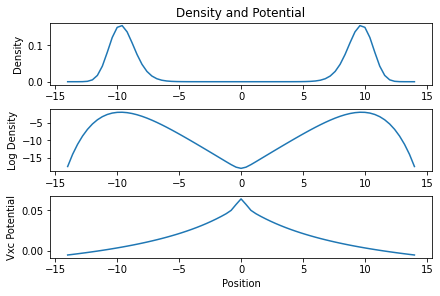

<Figure size 432x288 with 0 Axes>



For time step from  0.510 to  0.515
Density error = 9.94e-12


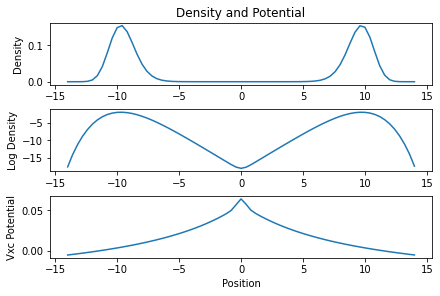

<Figure size 432x288 with 0 Axes>



For time step from  1.010 to  1.015
Density error = 9.94e-12


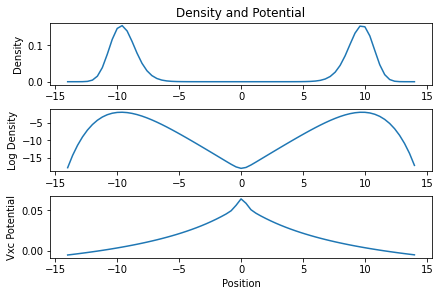

<Figure size 432x288 with 0 Axes>



For time step from  1.510 to  1.515
Density error = 9.96e-12


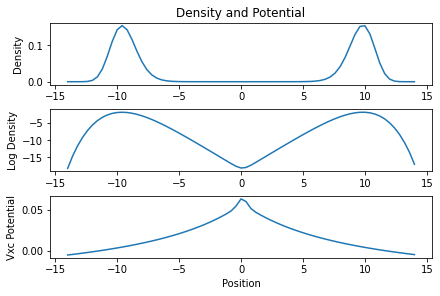

<Figure size 432x288 with 0 Axes>



For time step from  2.010 to  2.015
Density error = 9.93e-12


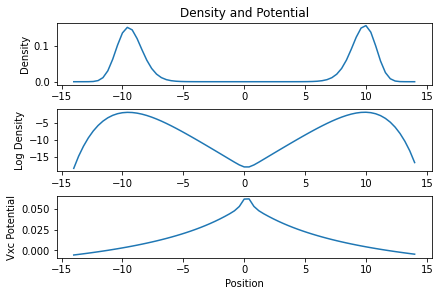

<Figure size 432x288 with 0 Axes>



For time step from  2.510 to  2.515
Density error = 9.95e-12


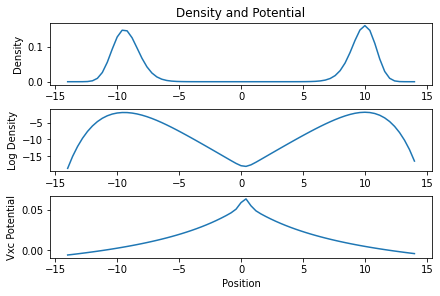

<Figure size 432x288 with 0 Axes>



For time step from  3.010 to  3.015
Density error = 1.00e-11


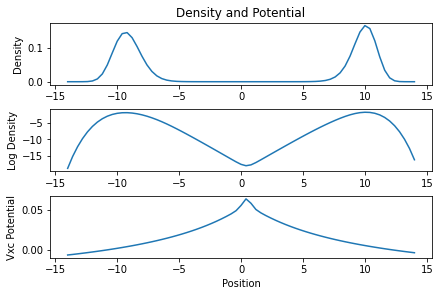

<Figure size 432x288 with 0 Axes>



For time step from  3.510 to  3.515
Density error = 1.00e-11


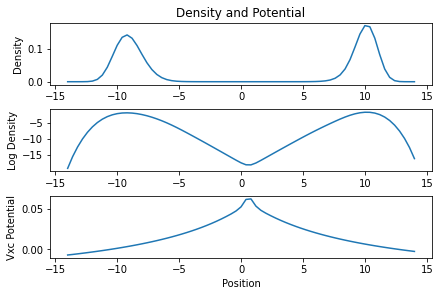

<Figure size 432x288 with 0 Axes>



For time step from  4.010 to  4.015
Density error = 1.01e-11


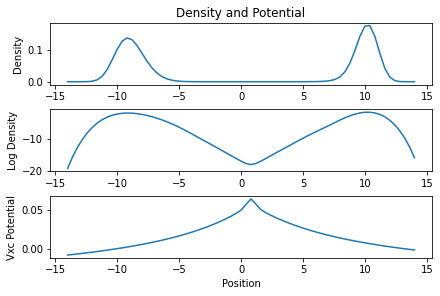

<Figure size 432x288 with 0 Axes>



For time step from  4.510 to  4.515
Density error = 1.01e-11


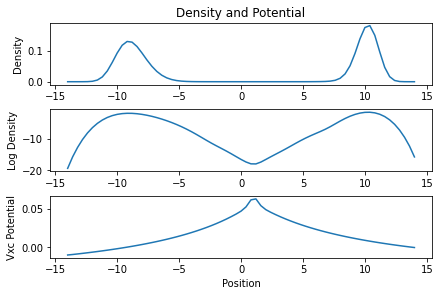

<Figure size 432x288 with 0 Axes>



For time step from  5.010 to  5.015
Density error = 1.00e-11


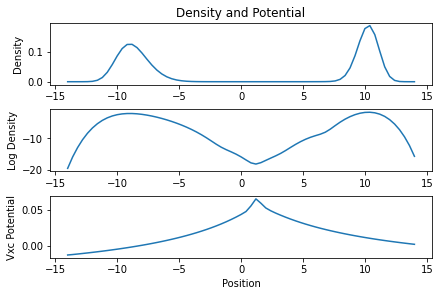

<Figure size 432x288 with 0 Axes>



For time step from  5.510 to  5.515
Density error = 9.97e-12


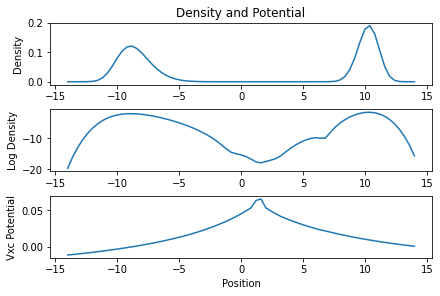

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

for loop in range(1110):
    
    
    # generate wavefunction at ct+dt
    td.propagate.advancewf(sysparams,sharedvals,25,fullvals.v,fullvals.psi,psinew)
    
    #Calculate density, first derivative of density and second derivative of density 
    #at time ct using psi
    td.density.fullwf_density(sysparams,fullvals.psi,dpe)
    td.density.calcdnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,dnx)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)
    
    #Calculate density and second derivative of density at time ct+dt using psinew
    td.density.fullwf_density(sysparams,psinew,dpenew)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,psinew,fullvals.v,ddnxnew)
    
    #Attempt to advance KS system
    info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)
    
    if (loop%100==3):
        print('\n')
        print('For time step from {0:6.3f} to {1:6.3f}'.format(sysparams.ct,sysparams.ct+sysparams.dt))
        print('Density error = {0:5.2e}'.format(np.linalg.norm(dpenew-KSvals.dp)))
        fig = plt.figure(constrained_layout=True)
        spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig)
        f_ax1 = fig.add_subplot(spec2[0, 0])
        f_ax2 = fig.add_subplot(spec2[2, 0])
        f_ax3 = fig.add_subplot(spec2[1, 0])
        fig=plt.figure()
        fig.subplots_adjust(top=0.8)
        f_ax1.set_ylabel('Density')
        f_ax1.set_title('Density and Potential')
        f_ax2.set_ylabel('Vxc Potential')
        f_ax2.set_xlabel('Position')
        f_ax3.set_ylabel('Log Density')
        line,=f_ax3.plot(sysparams.xlattice,np.log(dpe))
        line,=f_ax1.plot(sysparams.xlattice,dpe)
        line,=f_ax2.plot(sysparams.xlattice,KSvals.vks-sharedvals.v1)
        plt.show()
        
    
    
    if (info==1):#succesful advance of orbitals shift full wavefunction
        fullvals.psi=psinew